# Задание 2.1. Тестирование стратегии статистического арбитража

# Цель задания:
### 1. Получить первичные навыки построения и тестирования стратегий
### 2. Получить представление об основных инструментах языка Python (классы, функции)
### 3. Реализовать стратегию статистического арбитража 

### Рекомендуемая литература:
### 1.Y.Hilpish "Python for Finance"
### 2.J.M. Weiming "Mastering Python for Finance"
### 3.W. McKinney "Python for Data Analysis"

## 1. Загрузка библиотек

In [10]:
import numpy as np
import pandas as pd

In [11]:
from scipy import stats # статистическая библиотека  

In [12]:
from sklearn.linear_model import LinearRegression # регрессионный анализ  

In [13]:
from __future__ import division

In [14]:
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 

In [15]:
from datetime import datetime,timedelta # работа с форматом даты

In [16]:
import statsmodels.tsa.stattools as st ### анализ временных рядов

## 2. Загрузка данных

### В качестве примера будем использовать данные по индексам DJI и S&P

In [17]:
path='/home/maxime/Documentos/Strategies/'

In [18]:
dj=pd.read_csv(path+'^DJI.csv')

In [19]:
dj['Date']=dj['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 

In [20]:
sp=pd.read_csv(path+'^GSPC.csv')

In [21]:
sp['Date']=sp['Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d')) 

In [22]:
port=pd.merge(dj[['Date','Adj Close']],sp[['Date','Adj Close']],on=['Date'])

In [23]:
port.columns=['Date','DJ','SP']

In [24]:
port.head()

,Date,DJ,SP
0,2014-02-11,15994.769531,1819.750000
1,2014-02-12,15963.940430,1819.260010
2,2014-02-13,16027.589844,1829.829956
3,2014-02-14,16154.389648,1838.630005
4,2014-02-18,16130.400391,1840.760010


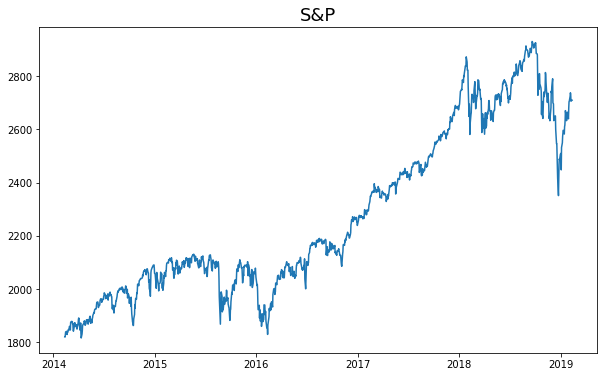

In [25]:
plt.figure(figsize=(10,6))
_=plt.plot(port.Date,port.SP)
_=plt.title('S&P',fontsize=18)

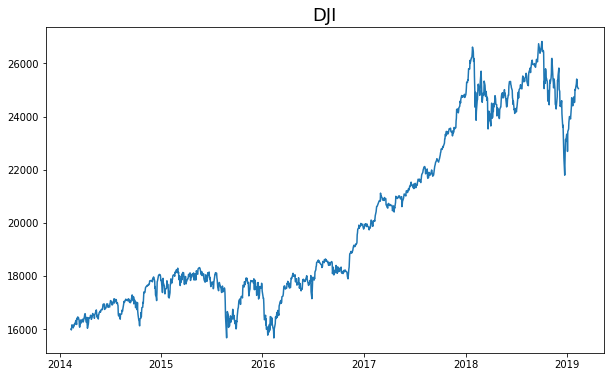

In [26]:
plt.figure(figsize=(10,6))
_=plt.plot(port.Date,port.DJ)
_=plt.title('DJI',fontsize=18)

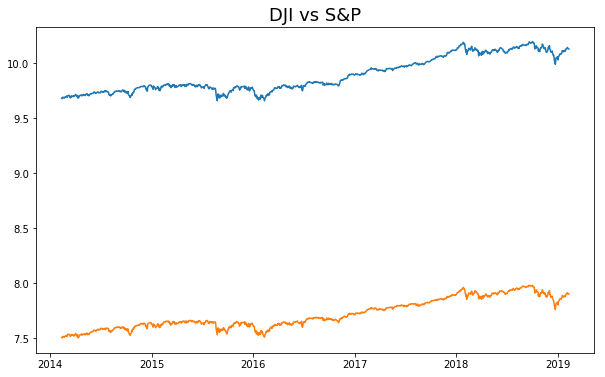

In [27]:
plt.figure(figsize=(10,6))
_=plt.plot(port.Date,np.log(port.DJ))
_=plt.plot(port.Date,np.log(port.SP))
_=plt.title('DJI vs S&P',fontsize=18)

## 3. Проверка на стационарность

In [28]:
X=(np.array(np.log(port.DJ))).reshape(-1,1)

In [29]:
Y=(np.array(np.log(port.SP))).reshape(-1,1)

In [30]:
reg=LinearRegression(fit_intercept=False).fit(X,Y)

In [31]:
(reg.coef_[0][0])

0.78058788885180208

In [32]:
Y_hat=reg.predict(X)

In [33]:
Y_resid=Y-Y_hat

In [34]:
Y_resid.ravel().shape

(1259,)

In [35]:
np.mean(Y_resid),np.std(Y_resid)

(-0.00014503826116187923, 0.016724007559889374)

In [36]:
st.adfuller(Y_resid.ravel())[1]

0.025283399661159882

In [37]:
np.repeat(np.mean(Y_resid),len(Y_resid))

array([-0.00014504, -0.00014504, -0.00014504, ..., -0.00014504,
       -0.00014504, -0.00014504])

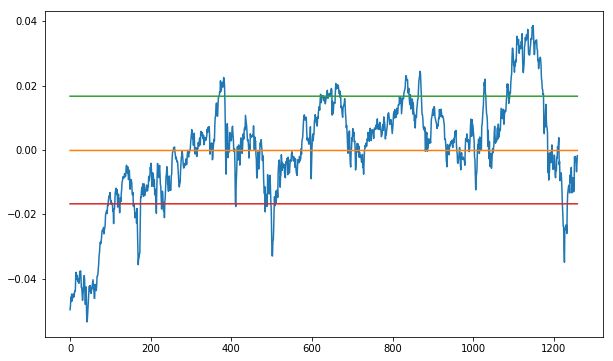

In [38]:
k=1
plt.figure(figsize=(10,6))
_=plt.plot(Y_resid)
_=plt.plot(np.repeat(np.mean(Y_resid),len(Y_resid)))
_=plt.plot(np.repeat(np.std(Y_resid)*k,len(Y_resid)))
_=plt.plot(np.repeat(np.std(Y_resid)*-k,len(Y_resid)))

## 4. Полезные функции

In [39]:
# расчет остатков уравнения регрессии
def reg_resid_func(Instr_1,Instr_2):
    Y=np.log(Instr_1)
    X=np.log(Instr_2)
    reg=LinearRegression(fit_intercept=False)
    reg.fit(X,Y)
    Y_pred=reg.predict(X)
    return((Y-Y_pred),reg.coef_[0][0])

In [40]:
# проверка на стационарность
def stationarity_check_func(data_spread,alpha=0.05):
    stationarity=False
    if st.adfuller(data_spread.ravel())[1]<alpha:
        stationarity=True
    return stationarity   

In [41]:
# расчет параметров рапсределения спрэда
def param_func(data_spread):
    return (np.mean(data_spread),np.std(data_spread))

In [42]:
# получение сингала
def signal_func_open(spread,mean,sigma,k):
    signal='No'
    if spread<=(mean-sigma*k):
        signal='Buy'
    elif spread>=mean+sigma*k:
        signal='Sell'
    return signal    

In [43]:
# преобазование значений цен в число с плавающей точкой
def get_prices(instr1,instr2):
    return (float(instr1),float(instr2))

## 5. Создание класса для описания позиции

### long:  first -buy, second-sell
### short: first - sell, second-buy

In [44]:
class Position(object):
    
    def __init__(self):
        self._initial_position=(None,None,0,0,0)
        #date_initial,direction,price_1,price_2,beta,comission
        self._close_position=(None,None,0,0,0)
        #date_close,signal,price_1,price_2,comission

    @property # вывод данных по открытию позиции
    def initial_position(self):
        return self._initial_position
    
    @initial_position.setter # ввод данных для открытия позиции
    def initial_position(self, initial_position):
        self._initial_position=initial_position
        

    @property # # вывод данных по закрытию позиции
    def close_position(self):
        return self._close_position
        
    
    @close_position.setter # ввод данных для закрытия позиции
    def close_position(self, close_position):
        self._close_position=close_position
        
        
    def get_result(self): # расчет результата
        Date_setup,Direction,Instr_1_Price_initial,Instr_2_Price_initial,Beta,Comission_init=self._initial_position
        Date_close,Close_type,Instr_1_Price_close,Instr_2_Price_close,Comission_close=self._close_position
        if ((Date_setup==None)|(Date_close==None)):
            return 0
        else:
            return ((np.log(Instr_1_Price_close)-np.log(Instr_1_Price_initial))\
                -(np.log(Instr_2_Price_close)-np.log(Instr_2_Price_initial))*Beta-Comission_init) if Direction=='Long'\
    else (-(np.log(Instr_1_Price_close)-np.log(Instr_1_Price_initial))\
          +(np.log(Instr_2_Price_close)-np.log(Instr_2_Price_initial))*Beta-Comission_close)

In [36]:
pos=Position()

In [37]:
initial_position=('2019-04-02','Short',5,6,1.1,0)

In [38]:
pos.initial_position=initial_position

In [39]:
pos.initial_position

('2019-04-02', 'Short', 5, 6, 1.1, 0)

In [40]:
pos.close_position=('2019-04-02','Signal',5,8,0)

In [41]:
pos.close_position

('2019-04-02', 'Signal', 5, 8, 0)

In [42]:
pos.get_result()

0.31645027969695888

## 6. Реализация стратегии

In [45]:
port_reduced=port[(port.Date>'2015-01-01')&(port.Date<'2019-01-01')]

In [50]:
n=port_reduced.shape[0]
n

1006

In [56]:
# преобразование первоначального массива цен в формат, необходимый для уравнения регрессии
Instr_1=(np.array((port_reduced.iloc[0:,1]))).reshape(-1,1)
Instr_2=(np.array((port_reduced.iloc[0:,2]))).reshape(-1,1)
Date=list((port_reduced.iloc[0:,0]))

In [57]:
# инициализация параметров стратегии
days_stationarity_check_max=20 # частота проверки на стационарность
days_position_max=3 # количество дней, которые мы держим позицию
window=250 # количество данных, используемых для проверки стационарности
k=1.0# mu +/- k*sigma
comission=0 # размер комиссиии
stop_profit=0.0001

In [58]:
# инициализация переменных 
result=[] # массив для фиксации результатов
stationarity_check=False
pos_days=0
i=window
stationatity_check_index=window 

In [59]:
while ((i)<n):
    #print(i)
    if (pos_days==0):
        if (((i-stationatity_check_index)>days_stationarity_check_max)|(i==window)):
            resid,beta=reg_resid_func(Instr_1[(i-window):i],Instr_2[(i-window):i])
            stationarity=stationarity_check_func(resid) # проверка на стационарность 
            if stationarity:
                mean,sigma=param_func(resid)
            stationatity_check_index=i
        if stationarity: # если ряд стационарен, проверяем наличие сигнала
            price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
            spread=float(np.log(price_1)-np.log(price_2)*beta)
            #print(np.log(price_1),np.log(price_2),spread,mean,sigma,(mean+sigma*k),beta)
            signal=signal_func_open(spread,mean,sigma,k)
            #print(signal)
            if (signal<>'No'):  # если есть сигнал, занимаем позицию            
                pos_direction='Long' if signal=='Buy' else 'Short' 
                pos=Position() 
                pos.initial_position=(Date[i],pos_direction,price_1,price_2,beta,comission)
                pos_days=1
                i+=1
            else: i+=1   
        else: i+=1      
    else:
        price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
        if (pos_days<days_position_max):# если время позиции не превысило лимит, проверяем результат
            pos.close_position=(Date[i],'Signal',price_1,price_2,comission)
            res=pos.get_result()
            if (res>stop_profit):# если результат положительный или stop-loss, закрываем позицию               
                result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
                pos_days=0
            else:
                pos_days+=1
                i+=1
        else:
            pos.close_position=(Date[i],'Time',price_1,price_2,comission)
            # если время позиции превысило лимит, закрываем позицию
            result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
            pos_days=0
            #print('Time_close')

In [60]:
df=pd.DataFrame(result,columns=['Date_open','Direction','Price_1_init','Price_2_init','Beta','Comission_init',\
                        'Date_close','Type','Price_1_close','Price_2_close','Comission_close','Result'])
# массив с результатами реализации стратегии

In [61]:
df

,Date_open,Direction,Price_1_init,Price_2_init,Beta,Comission_init,Date_close,Type,Price_1_close,Price_2_close,Comission_close,Result
0,2016-01-07,Short,16514.099609,1943.089966,1.280944,0,2016-01-12,Time,16516.220703,1938.680054,0,-0.0030
1,2016-01-12,Short,16516.220703,1938.680054,1.280944,0,2016-01-15,Time,15988.080078,1880.329956,0,-0.0066
2,2016-01-15,Short,15988.080078,1880.329956,1.280944,0,2016-01-21,Time,15882.679688,1868.989990,0,-0.0011
3,2016-01-21,Short,15882.679688,1868.989990,1.280944,0,2016-01-22,Signal,16093.509766,1906.900024,0,0.0125
4,2016-01-22,Short,16093.509766,1906.900024,1.280944,0,2016-01-27,Time,15944.459961,1882.949951,0,-0.0069
5,2016-01-27,Short,15944.459961,1882.949951,1.280944,0,2016-01-29,Signal,16466.300781,1940.239990,0,0.0062
6,2016-01-29,Short,16466.300781,1940.239990,1.280944,0,2016-02-01,Signal,16449.179688,1939.380005,0,0.0005
7,2016-02-01,Short,16449.179688,1939.380005,1.280908,0,2016-02-04,Time,16416.580078,1915.449951,0,-0.0139
8,2016-02-04,Short,16416.580078,1915.449951,1.280908,0,2016-02-09,Time,16014.379883,1852.209961,0,-0.0182
9,2016-02-09,Short,16014.379883,1852.209961,1.280908,0,2016-02-10,Signal,15914.740234,1851.859985,0,0.0060


In [62]:
sum(df.Result*1000000) # результат стратегии

-10300.0

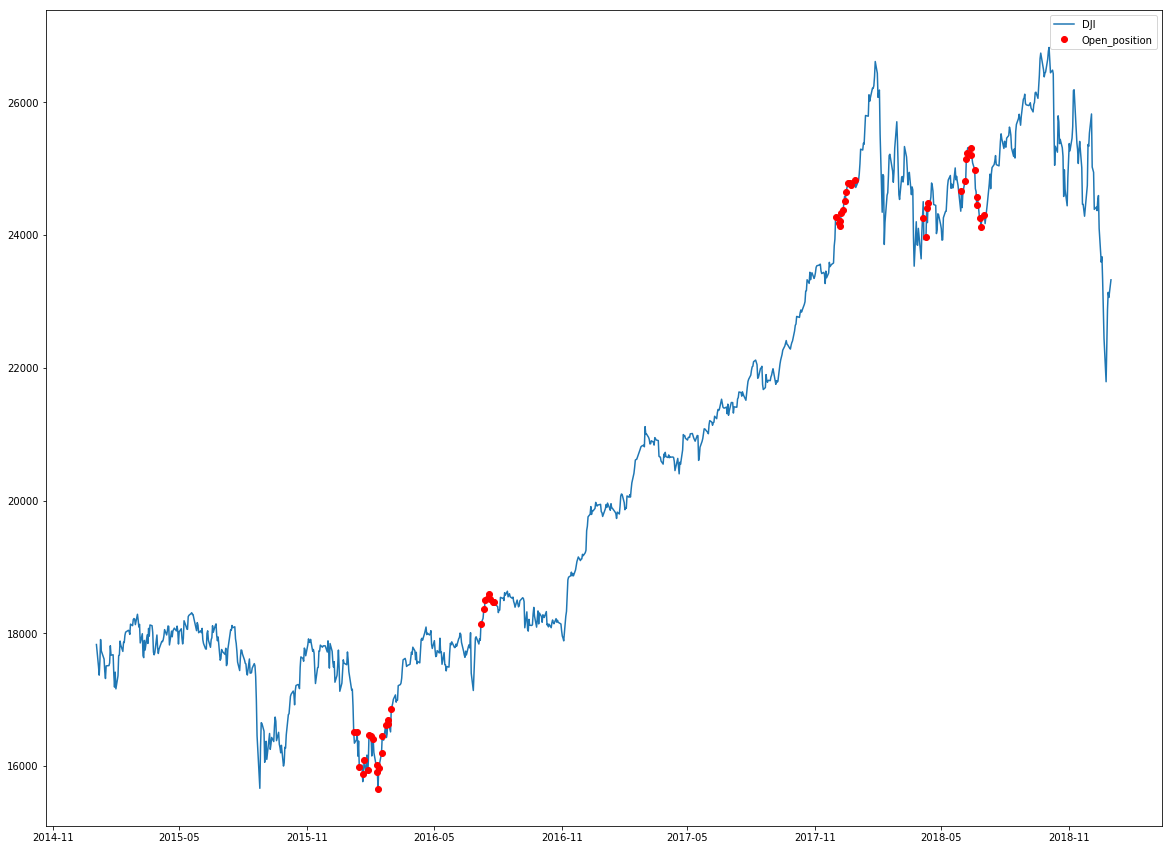

In [63]:
_=plt.figure(figsize=(20,15))
_=plt.plot(Date,Instr_1,label='DJI')
#_=plt.plot(Date,Instr_2,label='Fut_2')
plt.plot(df.Date_open,df.Price_1_init,'bo',color='red',label='Open_position')
__=plt.legend()

## Задание

### 1. Выбрать два актива, зависящих от сходных экономических факторов (или факторов риска).
### 2. Протестировать стратегию статистического арбитража по аналогии с разобранным примером.
### 3. Сделать выводы